## Chessboard Detection from Screenshot

In this notebook we show step by step how to detect and extract a chessboard from an image, assuming the image contains exactly one chessboard.

At the moment the algorithm has been tested only on two screenshots from chess.com and one screenshot from lichess.com. It currently fails for unconvential chessboard themes (see e.g. images/chesscom_3.png).

#### Workflow
1) Convert image to grayscale;
2) Find (by trial & error) a threshold pixel value (between 0 and 225) for which the light and dark squares appear as white and black on the thresholded image;
3) Use openCV's `findChessboardCornersSB` to identify the coordinates of the chessboard's four corners;
4) Crop out the chessboard;
5) TODO: scale the chessboard to 400*400 pixels (or maybe do this directly in Keras?).

In [12]:
import os
import cv2 as cv
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.dirname(os.getcwd())

# Select between lichess and chesscom images

img_no = 2

# img_name = "lichess_" + str(img_no)
img_name = "chesscom_" + str(img_no)

load_path = os.path.join(PROJECT_DIR, "images", img_name + ".png")

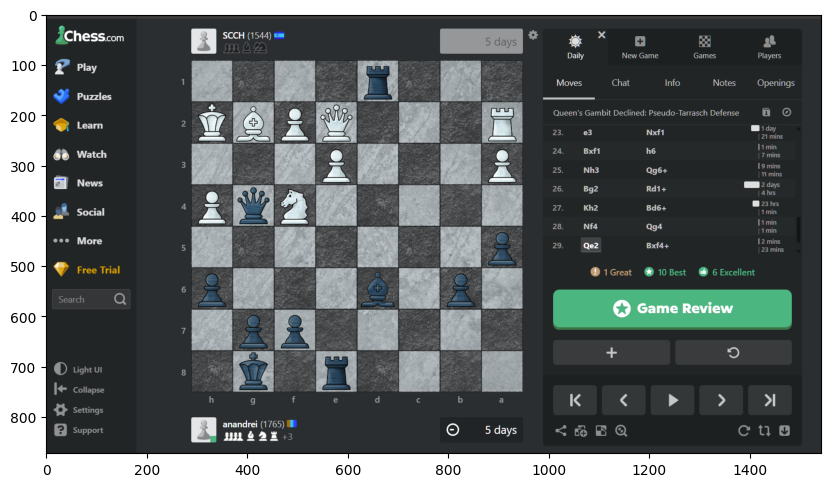

In [13]:
# Load the image
img = cv.imread(load_path)  # BGR order by default in openCV

if img is None:
    raise ValueError(f"Failed to load image from {load_path}")

# Convert to grayscale
gray = cv.cvtColor(src=img, code=cv.COLOR_BGR2GRAY)

# Set figure size globally
plt.rcParams["figure.figsize"] = (10,6)


plt.imshow(img)
plt.show()

### Binary thresholding + findChessboardCornersSB

...seems to work for simple cases. TODO: design an algorithm that finds a threshold such that the black & white chessboard can be detected by the openCV `findChessboardCornersSB` function.

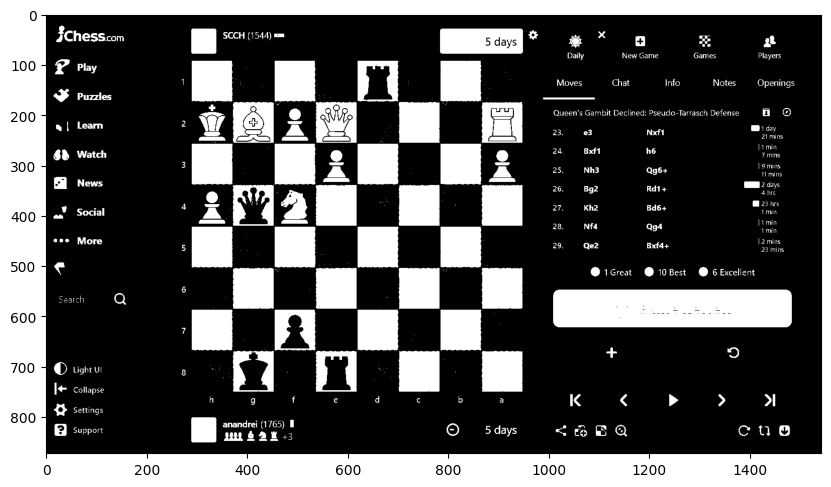

In [16]:
# Example of binary thresholding of a grayscale image

_, output = cv.threshold(
    src=gray,  # source image
    thresh=127,  # threshold value
    maxval=255,  # maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types
    type=cv.THRESH_BINARY  # thresholding type
)

plt.imshow(output, cmap="gray")
plt.show()

`findChessboardCornersSB` can only find the corners of the "inner" 6x6 chessboard. To find the corners of the full board, we first calculate the side of the square (in pixels) and extend the 6x6 board accordingly.

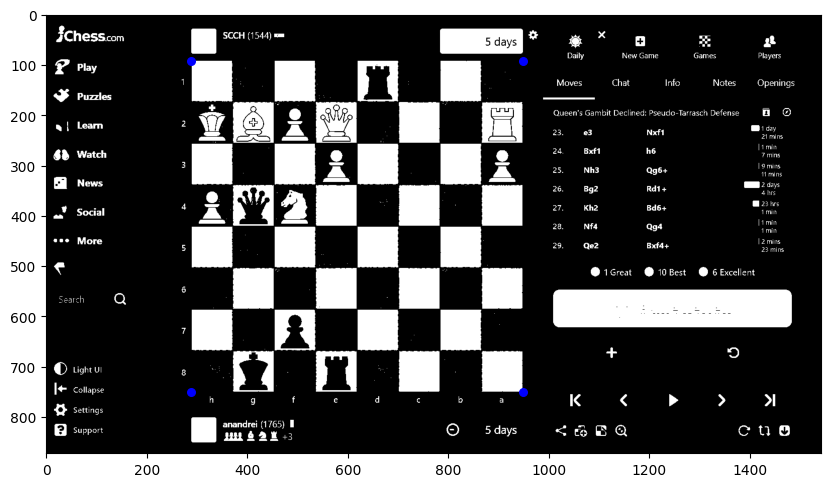

In [17]:
# Find the chessboard corners 

def find_chessboard_corners(img):
    
    found, points = cv.findChessboardCornersSB(
        image=img,
        patternSize=(7, 7),
        flags=cv.CALIB_CB_NORMALIZE_IMAGE + cv.CALIB_CB_EXHAUSTIVE 
    )  # points[-1, 0, :] is bottom right, points[0, 0, :] is top left

    if not found:
        return None

    right, bottom = points[-1, 0, :]
    left, top = points[0, 0, :]
    # Side of the square
    square = 0.5 * (right-left + bottom-top)/6
    
    right = int(right+square)
    left = int(left-square)
    top = int(top-square)
    bottom = int(bottom+square)

    return left, right, top, bottom


points = find_chessboard_corners(output)

if points:
    left, right, top, bottom = points
    
    plt.imshow(output, cmap="gray")
    # plt.scatter(points[:, 0, 0], points[:, 0, 1], c="blue", s=10)
    plt.scatter([left, right, left, right], [bottom, top, top, bottom], c="blue", s=30)
    plt.show()


(660, 660, 3)


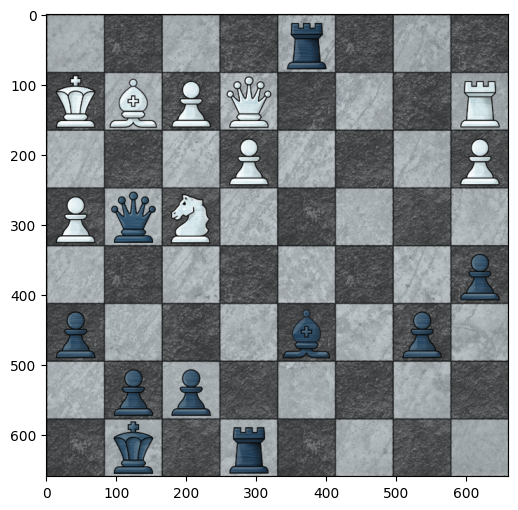

In [18]:
# Crop the image

def crop_chessboard(img):
    
    # hardcode thresholds to be tried
    thresholds = [127, 159, 191, 95, 223, 31]

    gray = cv.cvtColor(src=img, code=cv.COLOR_BGR2GRAY)

    for threshold in thresholds:
        
        _, output = cv.threshold(
            src=gray,  # source image
            thresh=threshold,  # threshold value
            maxval=255,  # maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types
            type=cv.THRESH_BINARY  # thresholding type
        )

        points = find_chessboard_corners(output)
        if points:
            left, right, top, bottom = points
            return img[top:bottom, left:right]
    
    return None

cropped = crop_chessboard(img)

if cropped is not None:
    print(cropped.shape)

    plt.imshow(cropped)
    plt.show()

(808, 808, 3)


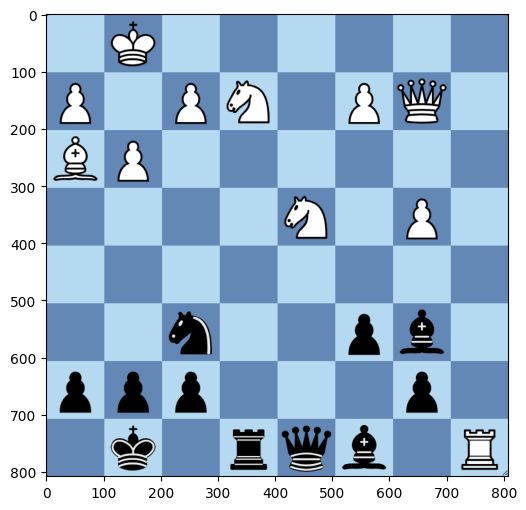

In [27]:
# Check if algorithm works for other images

img_name = "lichess_1"

load_path = os.path.join(PROJECT_DIR, "images", img_name + ".png")

# Load the image
img = cv.imread(load_path)

if img is None:
    raise ValueError(f"Failed to load image from {load_path}")

cropped = crop_chessboard(img)

if cropped is not None:
    print(cropped.shape)

    plt.imshow(cropped)
    plt.show()
else:
    print("Chessboard could not be found.")